In [2]:
import numpy as np
import tensorflow as tf
from utils_functions import *
from plan import *
import random
from main import *
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.layers import LSTM
#from tensorflow.keras.layers import RepeatVector
#from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils  import plot_model
#from tensorflow.keras.utils  import Sequence
from sklearn.model_selection import train_test_split
import datetime, os
import pandas as pd

In [2]:
# controllo di star effettivamente usando la GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print("nome gpu: ",tf.test.gpu_device_name())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
nome gpu:  /device:GPU:0


## Preparazione dati

### Preparazione dati per struttura Simil-CBOW

Creazione dataset

In [18]:
dizionario_stati = load_file("./dizionario_stati")
piani_caricati = load_file("./plans")

File loaded
File loaded


In [2]:
#ESEMPIO DI TEST
d = [
    [[0,0,0,0],[0,0,0,1],[0,0,0,2],[0,0,0,3],[0,0,0,4],[0,0,0,5],[0,0,0,6],[0,0,0,7]],
    [[1,1,1,0],[1,1,1,1],[1,1,1,2],[1,1,1,3],[1,1,1,4],[1,1,1,5],[1,1,1,6],[1,1,1,7],[1,1,1,8],[1,1,1,9]],
    [[2,2,2,0],[2,2,2,1],[2,2,2,2],[2,2,2,3],[2,2,2,4]],
    [[3,3,3,0],[3,3,3,1],[3,3,3,2],[3,3,3,3]],
    [[4,4,4,0],[4,4,4,1],[4,4,4,2],[4,4,4,3],[4,4,4,4],[4,4,4,5]]

]

In [3]:
new = dataset_augmentation(d)

In [4]:
print(new)
print(new.shape)

[[[0 0 0 0]
  [0 0 0 1]
  [0 0 0 2]
  [0 0 0 3]
  [0 0 0 4]]

 [[1 1 1 0]
  [1 1 1 1]
  [1 1 1 2]
  [1 1 1 3]
  [1 1 1 4]]

 [[1 1 1 5]
  [1 1 1 6]
  [1 1 1 7]
  [1 1 1 8]
  [1 1 1 9]]

 [[2 2 2 0]
  [2 2 2 1]
  [2 2 2 2]
  [2 2 2 3]
  [2 2 2 4]]

 [[4 4 4 0]
  [4 4 4 1]
  [4 4 4 2]
  [4 4 4 3]
  [4 4 4 4]]]
(5, 5, 4)


# Processo creazione dateset corretti

In [19]:


dataset = costruisci_vettore_per_piano(dizionario_stati,piani_caricati)

dataset_5x340 = dataset_augmentation(dataset)

In [12]:
print(dataset_5x340.shape)

(256153, 5, 340)


In [59]:
np.random.shuffle(dataset_5x340)

In [68]:
df = pd.DataFrame(dataset_5x340.tolist(), columns=['s0', 's1','s2','s3','s4'])

In [74]:
df

,s0,s1,s2,s3,s4
0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ..."
4,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ..."
...,...,...,...,...,...
256148,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, ..."
256149,"[1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, ...","[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ..."
256150,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..."
256151,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [75]:
X=df[["s0","s1","s3","s4"]]

In [71]:
Y=df["s2"]

In [77]:
#split
x_tmp, x_test, y_tmp, y_test = train_test_split(X,Y,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x_tmp,y_tmp,test_size = 0.25,train_size =0.75)

In [80]:
x_train


,s0,s1,s3,s4
198651,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
31781,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
184357,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
122569,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, ..."
27869,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
...,...,...,...,...
255190,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
38072,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ..."
78506,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
118222,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ..."


In [81]:
y_train

198651    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
31781     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
184357    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
122569    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...
27869     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...
                                ...                        
255190    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
38072     [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...
78506     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
118222    [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ...
230274    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
Name: s2, Length: 153691, dtype: object

In [82]:
x_test

,s0,s1,s3,s4
121870,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ..."
103691,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
707,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
232235,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
74661,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...
223598,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ..."
65876,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
190840,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."
179598,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [83]:
y_test

121870    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...
103691    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...
707       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
232235    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
74661     [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...
                                ...                        
223598    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...
65876     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
190840    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...
179598    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
37477     [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...
Name: s2, Length: 51231, dtype: object

In [88]:
x_train=x_train.to_numpy(dtype=object)
y_train=y_train.to_numpy(dtype=object)

x_val=x_val.to_numpy(dtype=object)
y_val=y_val.to_numpy(dtype=object)

x_test=x_test.to_numpy(dtype=object)
y_test=y_test.to_numpy(dtype=object)


In [115]:
#Metodi usati per ri-trasformare tutti gli array/liste in np array con np.int8
def convert_x_np(data):
    new_data=[]
    for seq in data:
        new_seq=[]
        for array in seq:
            np_a=np.array(array,dtype=np.int8)
            new_seq.append(np_a)
        np_seq=np.array(new_seq)
        new_data.append(np_seq)
    np_new_data=np.array(new_data)
    return np_new_data  

def convert_y_np(data):
    new_data=[]
    for array in data:
        np_a=np.array(array,dtype=np.int8)
        new_data.append(np_a) 
               
    np_new_data=np.array(new_data)
    print("Completato")
    return np_new_data  


In [114]:
np_x_train=convert_x_np(x_train)
np_y_train=convert_y_np(y_train)

np_x_val=convert_x_np(x_val)
np_x_test=convert_x_np(x_test)

np_y_val=convert_y_np(y_val)
np_y_test=convert_y_np(y_test)

In [119]:
save_file(np_x_train, "./Dataset/", "set_training_x")
save_file(np_x_val, "./Dataset/", "set_validation_x")
save_file(np_x_test, "./Dataset/", "set_test_x")
    
save_file(np_y_train, "./Dataset/", "set_training_y")
save_file(np_y_val, "./Dataset/", "set_validation_y")
save_file(np_y_test, "./Dataset/", "set_test_y")

set_training_x saved in ./Dataset/
set_validation_x saved in ./Dataset/
set_test_x saved in ./Dataset/
set_training_y saved in ./Dataset/
set_validation_y saved in ./Dataset/
set_test_y saved in ./Dataset/


# Modello

Caricamento dataset

In [3]:
train_x=load_file("./Dataset/set_training_x")
train_y=load_file("./Dataset/set_training_y")
val_x=load_file("./Dataset/set_validation_x")
val_y=load_file("./Dataset/set_validation_y")
test_x=load_file("./Dataset/set_test_x")
test_y=load_file("./Dataset/set_test_y")

File loaded
File loaded
File loaded
File loaded
File loaded
File loaded


In [ ]:
logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)

]



#PARAM:
#tf.keras.regularizers.L1(l1=1e-4)
param={"INPUT_SIZE" : "4,340" ,
"OUTPUT_SIZE":340,
"HIDDEN_SIZE" : 670,
"HIDDEN_SIZE2" : 134,
"HIDDEN_SIZE3" : None,
"CODE_SIZE" : 67,
"KERNEL_INIZIALIZER":"he_uniform",
"KERNEL_REGULIZER":tf.keras.regularizers.L2(l2=1e-5),
'BIAS_REGULARIZER': None,
"ACTIVATION":'relu',
"OPTIMIZER":tf.keras.optimizers.Adam(learning_rate=0.001),
"EPOCHS":400,
"BATCH_SIZE":150,
"BATCH_NORMAIZATION": 0
}

autoencoderV2=tf.keras.models.Sequential()

autoencoderV2.add(Input(shape=(4,340)))

autoencoderV2.add(Flatten())

autoencoderV2.add( Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add(Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"],name="embedding"))

autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add(Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add( Dense(param["OUTPUT_SIZE"], activation='sigmoid'))


#variare learning_rate beta_1,beta_2, da fare per ultimo
#batch_size ???
autoencoderV2.compile(optimizer=param["OPTIMIZER"], loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
history=autoencoderV2.fit(x=train_x,y=train_y, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(val_x,val_y), 
                        callbacks=my_callbacks)

In [30]:
autoencoderV2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1360)              0         
                                                                 
 dense_5 (Dense)             (None, 670)               911870    
                                                                 
 dense_6 (Dense)             (None, 134)               89914     
                                                                 
 embedding (Dense)           (None, 67)                9045      
                                                                 
 dense_7 (Dense)             (None, 134)               9112      
                                                                 
 dense_8 (Dense)             (None, 670)               90450     
                                                                 
 dense_9 (Dense)             (None, 340)              

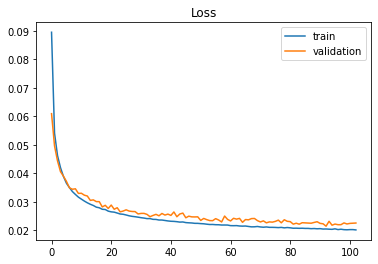

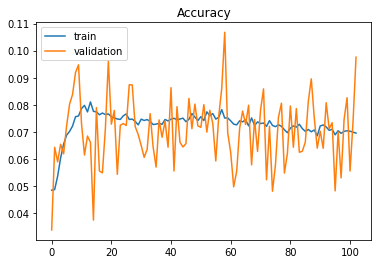

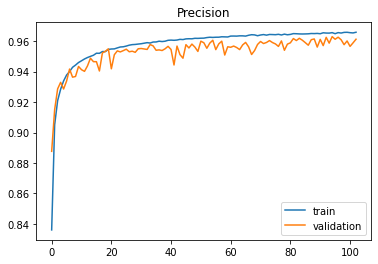

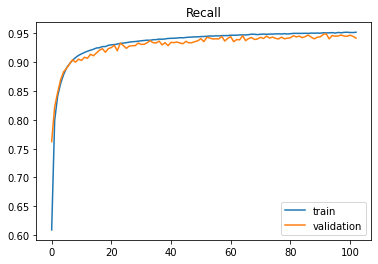

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss")
plt.show()
    
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.legend()
plt.title("Precision")
plt.show()

plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.legend()
plt.title("Recall")
plt.show()

In [28]:
y_test_predict= autoencoderV2.predict(test_x)


1601/1601 [==============================] - 3s 2ms/step


Numero di vettori decodificati correttamente: 21921 su 51231 totali 
Rapporto: 42.789% 
Media num di errori per array: 1.598



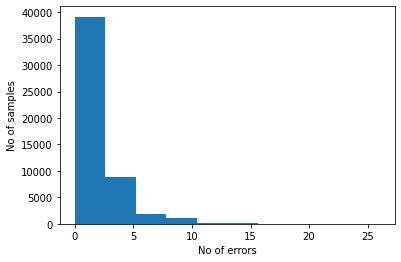

In [29]:
arr=results_info(test_y, y_test_predict,logdir)


In [ ]:
#Se è buono salvare (>90% rapporto vettori decodificati correttamente)

dir_model= os.path.join(logdir,"myModel")
autoencoderV2.save(dir_model)